In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

: 

In [43]:
path = r"C:\Users\Diego\Documents\DTU\Spring2024\MBML\european_vote_analysis\data\raw\Loan_default.csv"

In [ ]:
palette = itertools.cycle(sns.color_palette())

# Fix random generator seed for reproducibility
np.random.seed(42)

# Matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


loan_default_df = pd.read_csv(path)

# Convert categorical variables to numeric
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 
                       'HasDependents', 'LoanPurpose', 'HasCoSigner']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    loan_default_df[col] = label_encoders[col].fit_transform(loan_default_df[col])

# Normalize numerical features
numerical_columns = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                     'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
scaler = StandardScaler()
loan_default_df[numerical_columns] = scaler.fit_transform(loan_default_df[numerical_columns])

# Split the data into training and test sets
X = loan_default_df.drop(columns=['LoanID', 'Default'])
y = loan_default_df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

: 

In [60]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [76]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train-1)

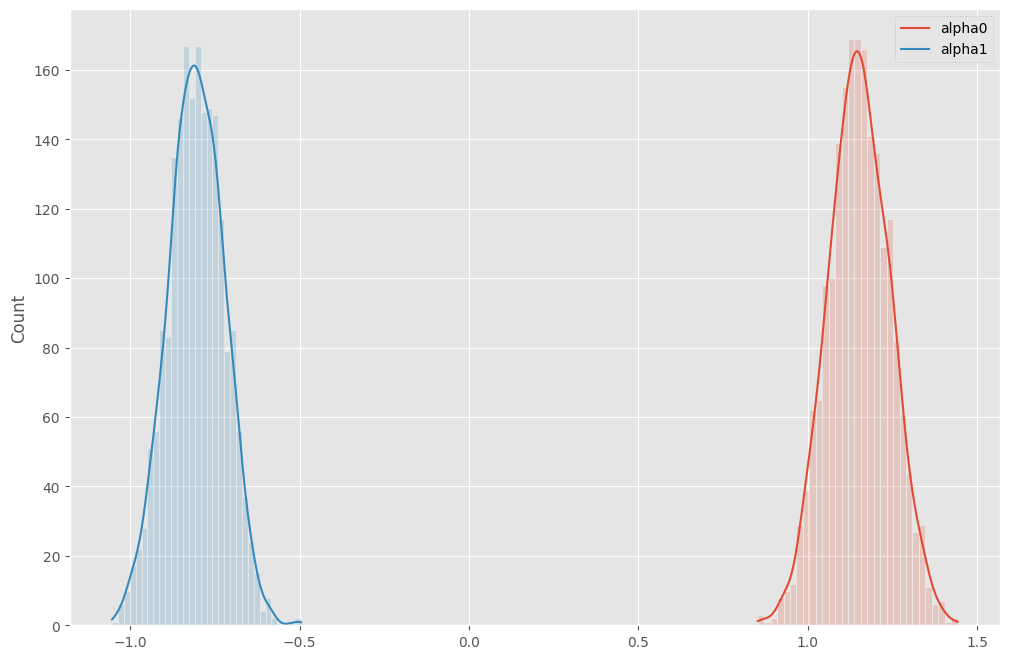

In [77]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

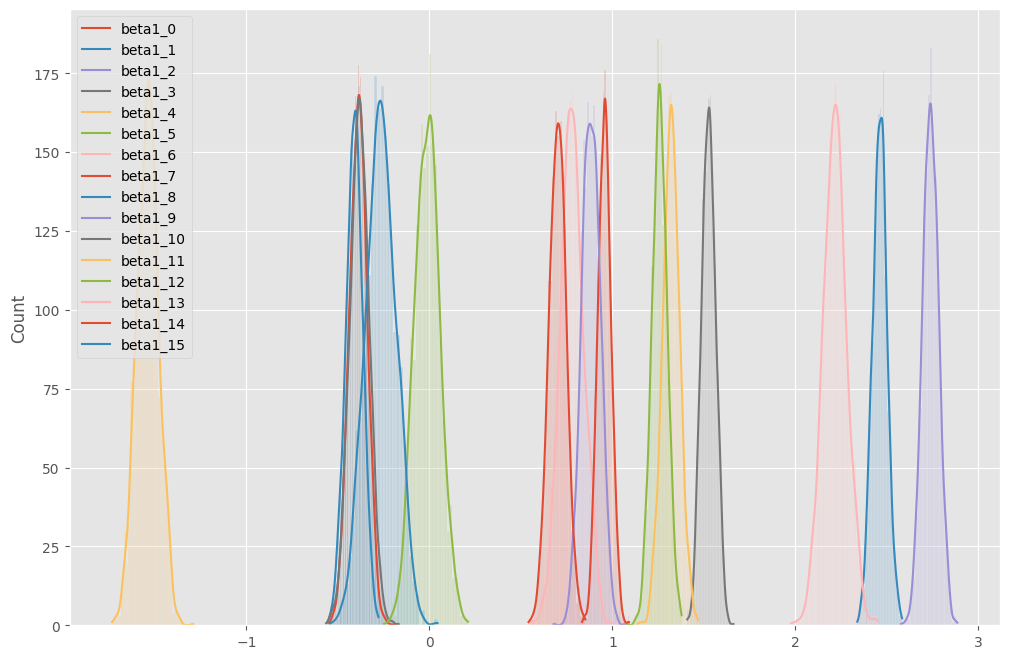

In [78]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d,0], kde=True, alpha=0.2)
plt.legend(["beta1_%d" % d for d in range(X.shape[1])])
plt.show()

In [79]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

In [83]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat != y_test) / len(y_test))

predictions: [1 1 1 ... 1 1 1]
true values: 51139     0
71005     0
35684     0
174087    0
137952    0
         ..
35991     0
69680     0
184743    0
209406    0
123164    0
Name: Default, Length: 51070, dtype: int64
Accuracy: 0.8879772860779322


In [84]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if (step % 1000 == 0):
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 408691.8


KeyboardInterrupt: 

In [75]:
y_hat

array([-3.23558958, -2.92110602, -2.20350067, ..., -2.27885436,
       -2.01577463, -3.69090039])

In [73]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

In [ ]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1) + 1

In [71]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=0)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: 45884
true values: 51139     0
71005     0
35684     0
174087    0
137952    0
         ..
35991     0
69680     0
184743    0
209406    0
123164    0
Name: Default, Length: 51070, dtype: int64
Accuracy: 0.0


In [69]:
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Accuracy: 0.0


In [55]:
y_hat

array([-3.23558958, -2.92110602, -2.20350067, ..., -2.27885436,
       -2.01577463, -3.69090039])

In [57]:
# make predictions for test set
y_hat = torch.sigmoid(alpha_hat + np.dot(X_test, beta_hat))
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

TypeError: sigmoid(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

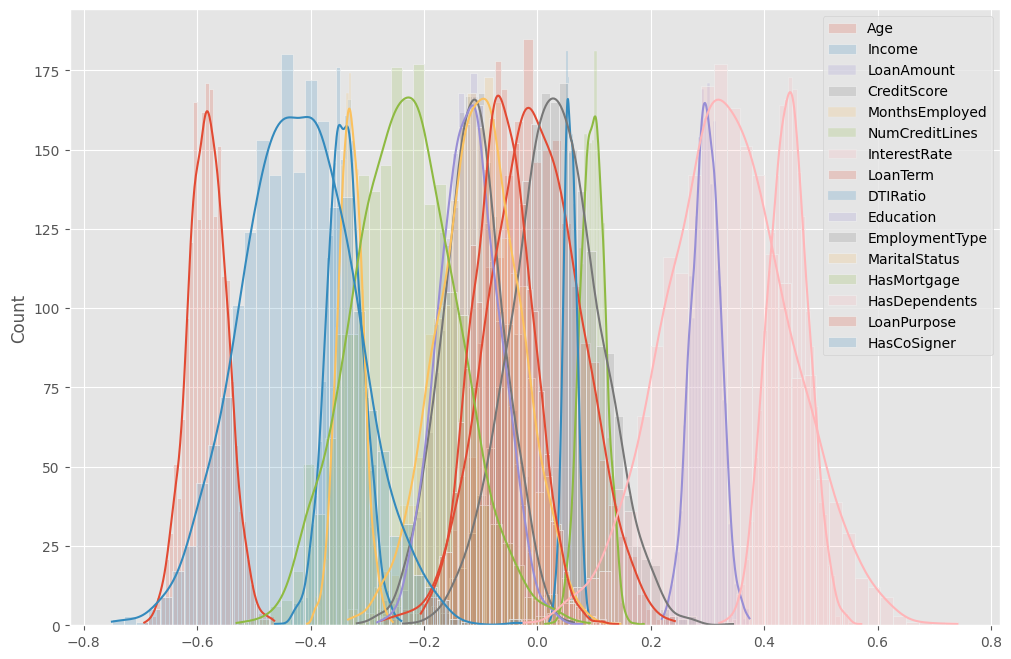

In [34]:
samples_beta = samples['beta'].detach().squeeze()
for d in range(X.shape[1]):
    sns.histplot(samples_beta[:,d], kde=True, alpha=0.2, label=X.columns[d])
plt.legend()
plt.show()

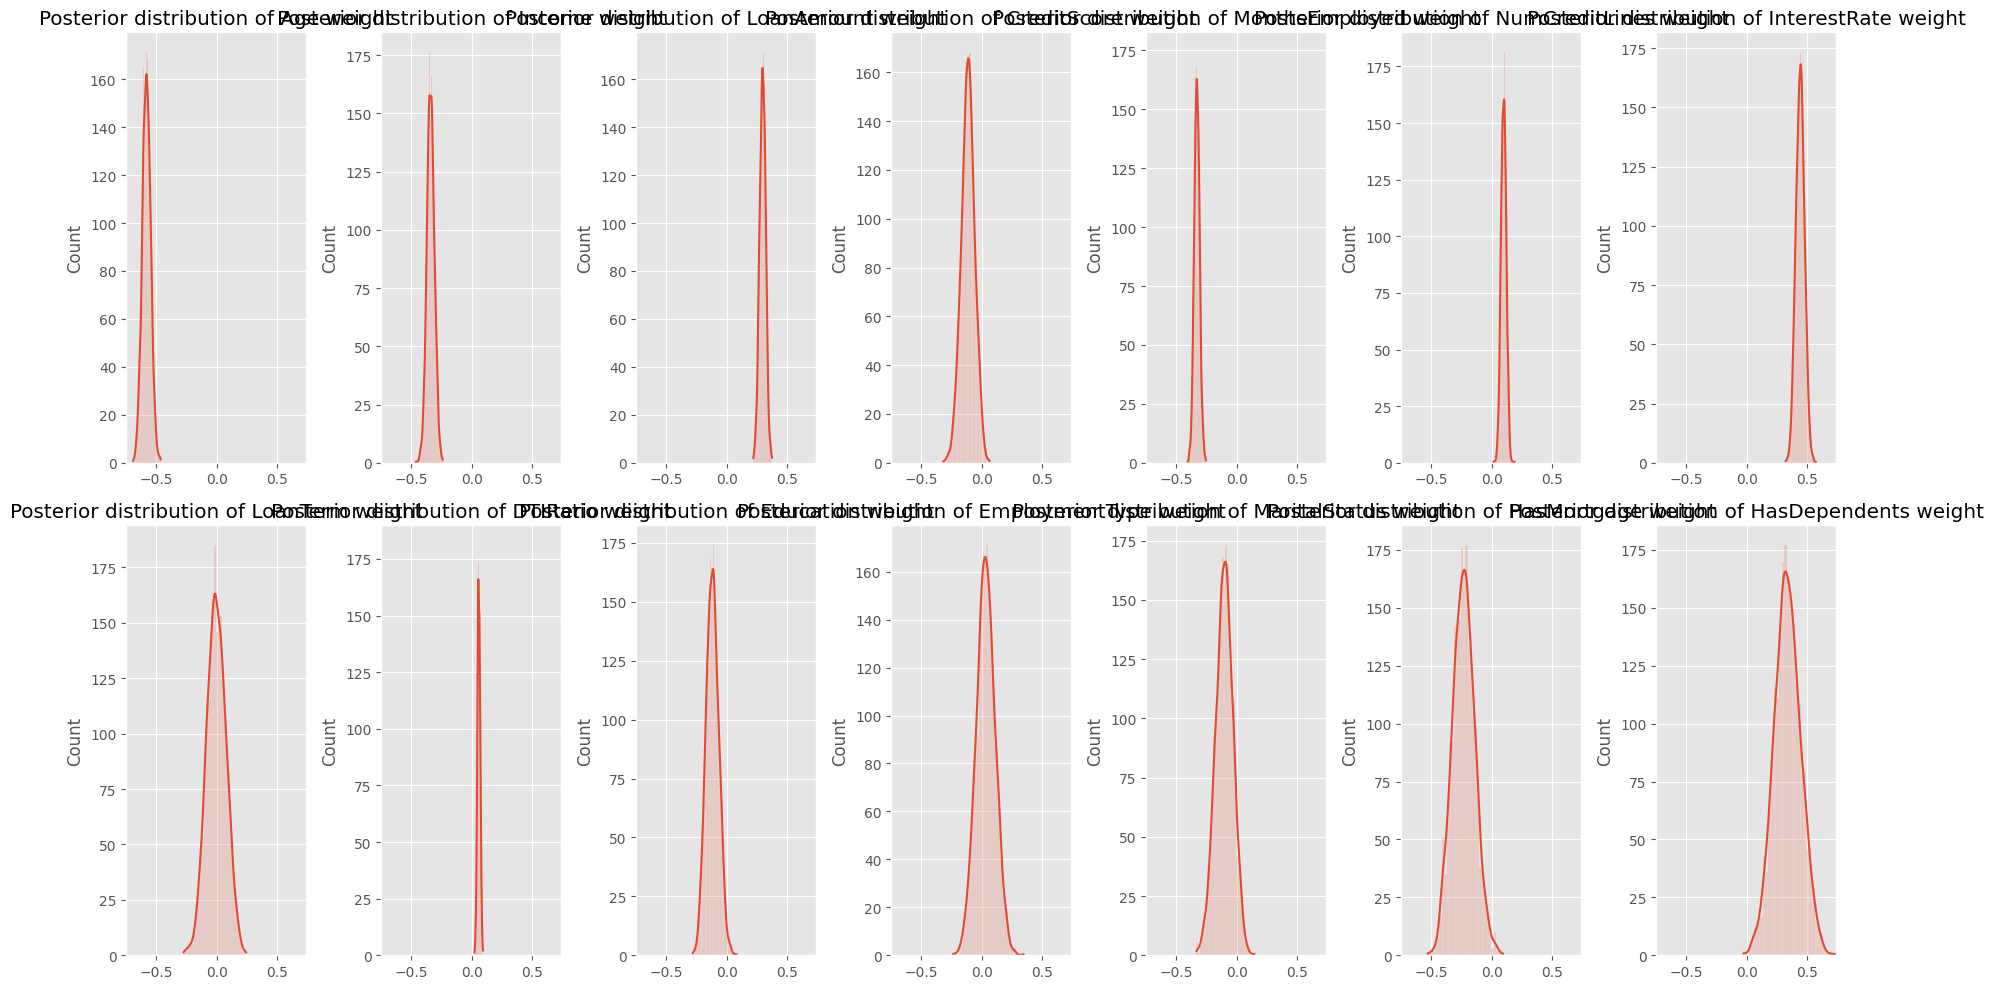

In [39]:
samples_beta = samples['beta'].detach().squeeze()

# Plot the posterior distributions of the weights (beta) with feature names
num_features = X.shape[1]
num_cols = 7
# num_rows = (num_features + num_cols - 1) // num_cols
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.set_xlim(samples_beta.min(), samples_beta.max())
    if i < num_features:
        sns.histplot(samples_beta[:, i], kde=True, alpha=0.2, ax=ax)
        ax.set_title(f"Posterior distribution of {X.columns[i]} weight")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()
